<a href="https://colab.research.google.com/github/Prudhvi0520/DataminingAssign1/blob/main/model_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/final/final/images.zip", 'r')
zip_ref.extractall("/content/images")
zip_ref.close()
!pip install livelossplot
import os 
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder 
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
import cv2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# understanding the dataset structure
data_dir = '../images/images/'
training_path = '/content/images/images/images/train/'
validation_path = '/content/images/images/images/validation/'


# Training classes
print("--------- Training set description --------------")
print("S.No.\tSample Count\tClass\t")
# Printing distribution of each class in training set
for (i,expression) in enumerate(os.listdir(training_path)):
    print(str(i+1)+ "\t"+ str(len(os.listdir(training_path + expression))) + "\t\t" + expression )
    

# Validation classes
print("\n--------- Validation set description --------------")
print("S.No.\tSample Count\tClass\t")
# Printing distribution of each class in training set
for (i,expression) in enumerate(os.listdir(validation_path)):
    print(str(i+1)+ "\t"+ str(len(os.listdir(validation_path + expression))) + "\t\t" + expression )


--------- Training set description --------------
S.No.	Sample Count	Class	
1	436		disgust
2	4982		neutral
3	7164		happy
4	3205		surprise
5	4103		fear
6	4938		sad
7	3993		angry

--------- Validation set description --------------
S.No.	Sample Count	Class	
1	111		disgust
2	1216		neutral
3	1825		happy
4	797		surprise
5	1018		fear
6	1139		sad
7	960		angry


In [15]:
def create_dataset(main_path):
    label_encoder = LabelEncoder()

    df = {"img":[],"img_class":[]}
    for class_names in os.listdir(main_path):
        for img_path in glob.glob(f"{main_path}/{class_names}/*"):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            img = img[..., np.newaxis] / 255.0         
            df["img"].append(img)
            df["img_class"].append(class_names)
    df["img"] = np.array(df["img"], dtype='float32')
    df["img_class"] = label_encoder.fit_transform(df["img_class"])
    df["img_class"] = tf.keras.utils.to_categorical(df["img_class"])
    return df["img"],df["img_class"]
    
training_dataset, training_labels = create_dataset(training_path[:len(training_path)-1])
validation_dataset, validation_labels  = create_dataset(validation_path[:len(validation_path)-1])



In [16]:
# Defining constants 
BATCH_SIZE = 64
img_channel = 3
LEARNING_RATE = 0.0001

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='reflect'
)


<h3>Building Model</h3>

In [18]:

from tensorflow.keras.layers import Dense,  Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam


model = Sequential()

# 1 - Convolution
model.add(Conv2D(32, (3, 3),  input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))


# 2nd Convolution layer
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)       2

In [19]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3,mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)

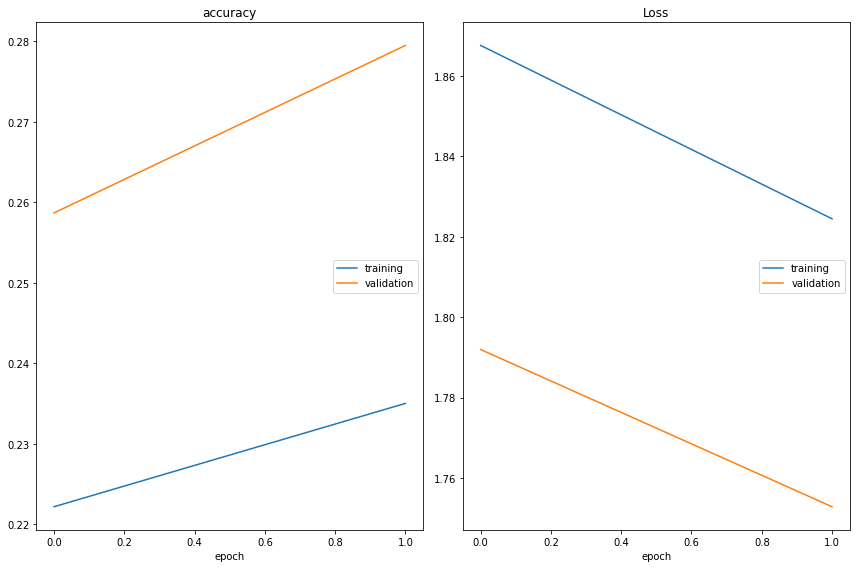

accuracy
	training         	 (min:    0.222, max:    0.235, cur:    0.235)
	validation       	 (min:    0.259, max:    0.280, cur:    0.280)
Loss
	training         	 (min:    1.824, max:    1.868, cur:    1.824)
	validation       	 (min:    1.753, max:    1.792, cur:    1.753)

Epoch 2: val_loss improved from 1.79195 to 1.75284, saving model to best_weights.h5
451/451 [==============================] - 148s 328ms/step - loss: 1.8245 - accuracy: 0.2350 - val_loss: 1.7528 - val_accuracy: 0.2795


In [ ]:
history = model.fit(
    data_augmentation.flow(training_dataset, training_labels, batch_size=BATCH_SIZE),    
    epochs=100,
    callbacks=[PlotLossesCallback(),checkpoint, early_stopping],
    validation_data=(validation_dataset,validation_labels))


In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")